In [112]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Functions: stepsize regiem

In [113]:
def initialise_boundary(top, left, right, bottom, T_ambient, corners=[0,0,0,0], Get_T_K=True):
    cols = len(top)+2
    rows = len(left)+2
    
    middle_zeros = np.array([0 for i in top])
    
    if Get_T_K:
        middle_ambient = np.array([T_ambient for i in top])
    
    if corners == [0,0,0,0]:
        initial_top = np.append(np.append([(top[0]+left[0])/2],top), [(top[-1]+right[0])/2])
        initial_bottom = np.append(np.append([(bottom[0]+left[-1])/2],bottom), [(bottom[-1]+right[-1])/2])
    else:
        initial_top = np.append(np.append([corners[0]],top), [corners[1]])
        initial_bottom = np.append(np.append([corners[2]],bottom), [corners[3]])
    
    
    
    middle = np.array(np.append([np.append(np.append([left[i]], middle_zeros), [right[i]]) for i in range(rows-2)],[]))
    
    if Get_T_K:
        middle_ambient = np.array(np.append([np.append(np.append([left[i]], middle_ambient), [right[i]]) for i in range(rows-2)],[]))
    
    initial_array = np.append(np.append(initial_top, middle), initial_bottom)
    initial_matrix_T_0 = np.matrix(initial_array.reshape(rows, cols))
    
    if Get_T_K:
        initial_array = np.append(np.append(initial_top, middle_ambient), initial_bottom)
        initial_matrix_T_k = np.matrix(initial_array.reshape(rows, cols))
        return initial_matrix_T_0, initial_matrix_T_k
    
    
    return initial_matrix_T_0

In [114]:
def update_with_source(T_k, T_0, q, h):
    # This new update function will use the fact that there will be a source term at each of the points
    # it will also update the new T_0 with the BC
    
    T_kP1 = T_0.copy()
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            # q is in terms of stepsize therefore no h^2
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j]) + 1/4 * q *h **2 / (K_si*293)
            
    T_0_new = update_processor_boundary(T_kP1, T_0, h)
    
    return T_kP1, T_0_new

In [115]:
def update_processor_boundary(T_k, T_0, h):
    # Take in T_k wich has a border of imaginary values
    # We want to update every value on the T_0 boundary
    # This is done by taking the value of T_k at the boundary (1 before the imagniary points)
    # Then calculating the gradient due to natural convection
    # Then creating new imaginary points which are then used to update the T_0
    
    T_a = 293
    K_si = 150*1e-4

    # we will do the top first
    top = T_k[1].A1[1:-1] # get rid of the end terms with the [1:-1] term
    second_top = T_k[2].A1[1:-1]
    grad_top = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in top]) 
    new_top = new_imaginary_points(grad_top, second_top, h)
    
    col_list = T_k.transpose()
    left = col_list[1].A1[1:-1]
    second_left = col_list[2].A1[1:-1]
    grad_left = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in left])
    new_left = new_imaginary_points(grad_left, second_left, h)
    
    bottom = T_k[-2].A1[1:-1]
    second_bottom = T_k[-3].A1[1:-1]
    grad_bottom = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in bottom])
    new_bottom = new_imaginary_points(grad_bottom, second_bottom, h)
    
    right = col_list[-2].A1[1:-1]
    second_right = col_list[-3].A1[1:-1]
    grad_right = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in right])
    new_right = new_imaginary_points(grad_right, second_right,  h)
    
    T_0_new = initialise_boundary(new_top, new_left, new_right, new_bottom, T_a, [0,0,0,0], Get_T_K=False)
    return T_0_new

In [116]:
def new_imaginary_points(grad, previous_points, h):
    return previous_points + 2*h*grad

In [117]:
def gradient_nat_convection(T_k_i, T_ambient, k_silicon, h):
    value = -1.31*1e-8 * (T_ambient)**(1/3)/ k_silicon * (T_k_i-1)**(4/3)
    #print(value)
    return value


In [118]:
def plot(T):
    fig, ax = plt.subplots()
    im = ax.imshow(T, cmap='plasma')
    plt.show()
    #fig.suptitle('Temperature map')
    #cbar = ax.figure.colorbar(im, orientation='horizontal')
    #cbar.ax.set_xlabel('Temperature Scale')
    #plt.show()

# Code Run

In [119]:
q = 0.5*1e-3
T_a = 293
K_si = 150*1e-4
h = 1

In [124]:
ambient = 31

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [125]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

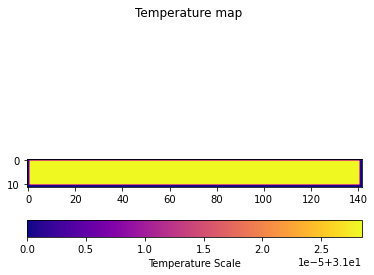

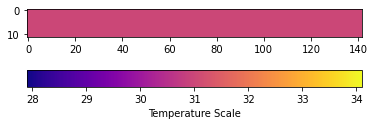

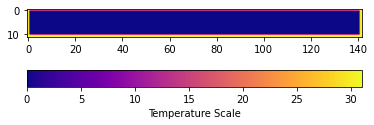

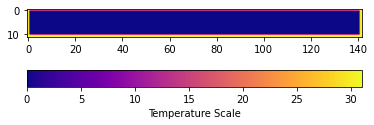

30.99894702042196 31.0


In [126]:
# First update
fig, ax = plt.subplots()
im = ax.imshow(T_k_updated, cmap='plasma')
fig.suptitle('Temperature map')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# Initial (should be all 33)
fig, ax = plt.subplots()
im = ax.imshow(T_k, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# T_0
fig, ax = plt.subplots()
im = ax.imshow(T_0, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# T_0_updated
fig, ax = plt.subplots()
im = ax.imshow(T_0_updated, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

print(T_0_updated[0,2], T_0[0,2])

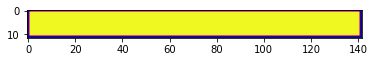

30.999834260023057 -0.00016573997694280251


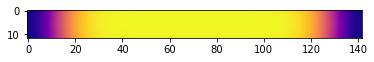

30.999995600497808 -2.7518858303210436e-09


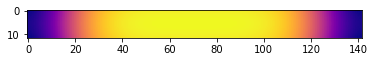

30.999994875000397 -2.9849260840819625e-09


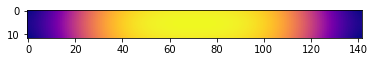

30.999994120369536 -3.042206486725263e-09


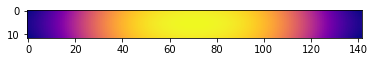

30.999993356537782 -3.0656543970053463e-09


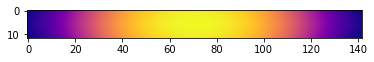

30.999992588467663 -3.077627042102904e-09


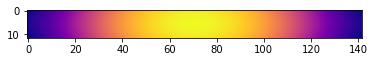

30.999991818053864 -3.084817734588796e-09


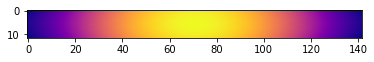

30.999991046193173 -3.089610345341498e-09


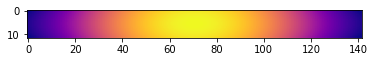

30.99999027336874 -3.092907263635425e-09


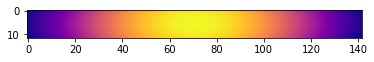

30.999989499864565 -3.0951241569709964e-09


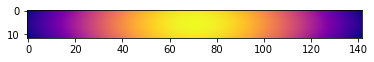

30.999988725858017 -3.0968365649641783e-09


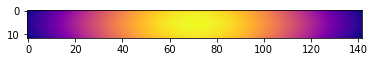

30.999987951465346 -3.0982043597305164e-09


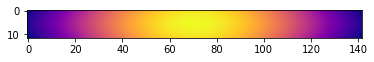

30.999987176765913 -3.0991600397101138e-09


KeyboardInterrupt: 

In [127]:
avT_k_1 = ambient
diff_array = []
av_array = []

for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    
    avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
    diff = avT_k-avT_k_1
    avT_k_1 = avT_k
    
    if i%250 == 0:
        plot(T_k_updated)        
        print(avT_k, diff)

    if i%100 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

# Functions: m regiem

In [128]:
def update_processor_boundary(T_k, T_0, h):
    # Take in T_k wich has a border of imaginary values
    # We want to update every value on the T_0 boundary
    # This is done by taking the value of T_k at the boundary (1 before the imagniary points)
    # Then calculating the gradient due to natural convection
    # Then creating new imaginary points which are then used to update the T_0
    
    T_a = 293
    K_si = 150
    
    # we will do the top first
    top = T_k[1].A1[1:-1] # get rid of the end terms with the [1:-1] term
    second_top = T_k[2].A1[1:-1]
    grad_top = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in top]) 
    new_top = new_imaginary_points(grad_top, second_top, h)
    
    col_list = T_k.transpose()
    left = col_list[1].A1[1:-1]
    second_left = col_list[2].A1[1:-1]
    grad_left = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in left])
    new_left = new_imaginary_points(grad_left, second_left, h)
    
    bottom = T_k[-2].A1[1:-1]
    second_bottom = T_k[-3].A1[1:-1]
    grad_bottom = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in bottom])
    new_bottom = new_imaginary_points(grad_bottom, second_bottom, h)
    
    right = col_list[-2].A1[1:-1]
    second_right = col_list[-3].A1[1:-1]
    grad_right = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in right])
    new_right = new_imaginary_points(grad_right, second_right,  h)
    
    T_0_new = initialise_boundary(new_top, new_left, new_right, new_bottom, T_a, [0,0,0,0], Get_T_K=False)
    return T_0_new

In [129]:
def gradient_nat_convection(T_k_i, T_ambient, k_silicon, h):
    value = - h_nat(T_k_i, T_ambient)/ k_silicon * (T_k_i - 1)
    return value
def h_nat(T_s_hat, T_a):
    return 1.31*(T_s_hat*T_a - T_a)**(1/3)

In [130]:
q = 0.5*1e9
T_a = 293
K_si = 150
h = 1e-4

In [160]:
ambient = 29

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [161]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

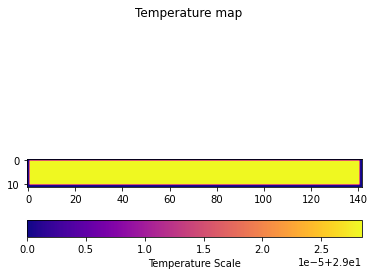

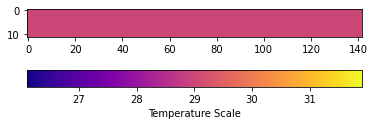

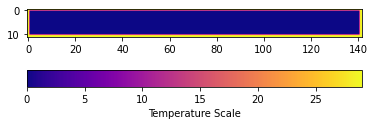

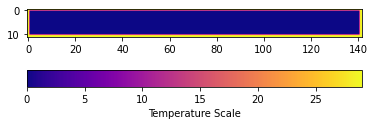

28.999042062293807 29.0


In [162]:
# First update
fig, ax = plt.subplots()
im = ax.imshow(T_k_updated, cmap='plasma')
fig.suptitle('Temperature map')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# Initial (should be all 33)
fig, ax = plt.subplots()
im = ax.imshow(T_k, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# T_0
fig, ax = plt.subplots()
im = ax.imshow(T_0, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

# T_0_updated
fig, ax = plt.subplots()
im = ax.imshow(T_0_updated, cmap='plasma')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xlabel('Temperature Scale')
plt.show()

print(T_0_updated[0,2], T_0[0,2])

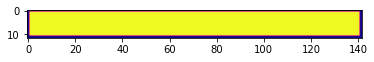

28.999874583204637 -0.00012541679536326455


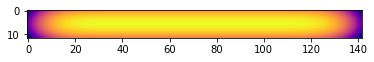

28.999530325224715 -8.445298860237926e-07


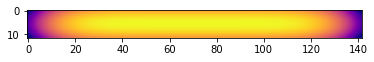

28.999326479574748 -7.948866453943992e-07


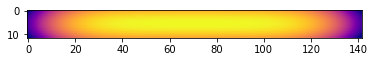

28.9991308172547 -7.727108837229935e-07


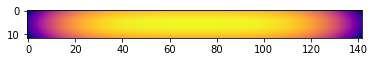

28.998939430092257 -7.593775492864552e-07


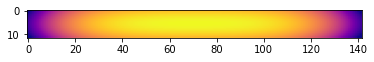

28.998750800396227 -7.50194104170987e-07


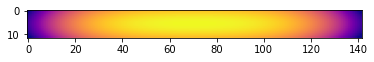

28.998564148533365 -7.433484334740115e-07


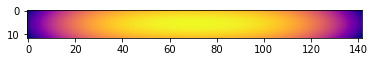

28.99837901065811 -7.379739876967051e-07


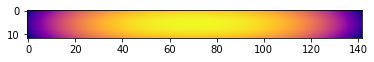

28.998195083833075 -7.33597076418846e-07


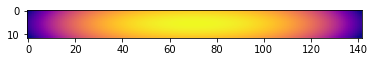

28.998012156623155 -7.299375752722881e-07


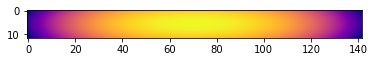

28.997830073689556 -7.268170030272358e-07


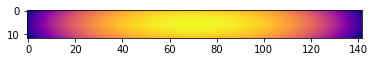

28.99764871606655 -7.241171857685913e-07


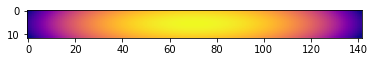

28.99746798949641 -7.217556650118695e-07


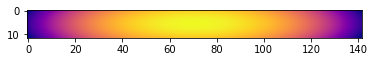

28.997287817220027 -7.196732738634637e-07


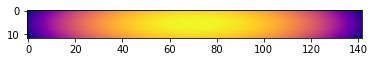

28.997108135364527 -7.178248893069394e-07


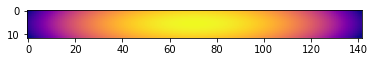

28.996928889893997 -7.161761139684586e-07


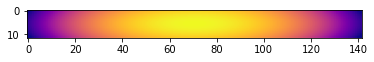

28.996750034526926 -7.146992651030359e-07


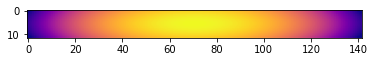

28.996571529264465 -7.133712109919088e-07


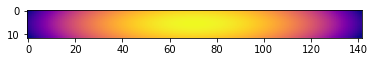

28.996393339312153 -7.121733247572593e-07


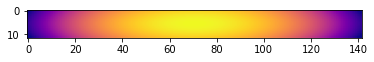

28.99621543426286 -7.110891111494766e-07


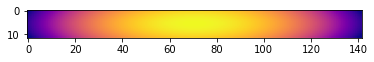

28.99603778745662 -7.101049277480342e-07


KeyboardInterrupt: 

In [163]:
avT_k_1 = ambient
diff_array = []
av_array = []

for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
    diff = avT_k-avT_k_1
    avT_k_1 = avT_k
    
    if i%250 == 0:
        plot(T_k_updated)        
        print(avT_k, diff)

    if i%100 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

In [ ]:
1+1/293*(7e6/(30*1.31))**(3/4)

In [ ]:
diff_array = []
av_array

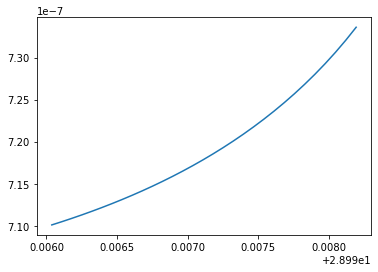

In [165]:
plt.plot((np.array(av_array)), abs(np.array(diff_array)))

In [168]:
1.011646*28

28.326088000000002